In [140]:
import matplotlib.pyplot as plt
# Compute correlation
from pathlib import Path, PurePath
import sys
import numpy as np
import matplotlib
# Find path to root folder
rootFolder = 'sounds-phd'
pathToRoot = Path().resolve()
while PurePath(pathToRoot).name != rootFolder:
    pathToRoot = pathToRoot.parent
sys.path.append(f'{pathToRoot}/01_algorithms/01_NR/02_distributed')
from danse_utilities.setup import apply_sro
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

fs = 16000                   # sampling frequency [samples/s] (true sampling rate)
dur = 5                    # signal duration [s]
nSignals = 1
srosToTest = np.linspace(0,2000,nSignals)   # SRO [ppm] 
srosToTest = np.insert(srosToTest, 0, 0)
signalType = 'noise'
signalType = 'speech'
delayFromReference = 0.1    # delay between microphones and reference signal [s]
# delayFromReference = 0    # delay between microphones and reference signal [s]

sensorToNodeTags = np.arange(1, nSignals+2)
nSamples = int(fs * dur)        # total number of samples
t = np.arange(nSamples) / fs
seed = 12345
rng = np.random.default_rng(seed)

Resampling x to 16000 samples/s.


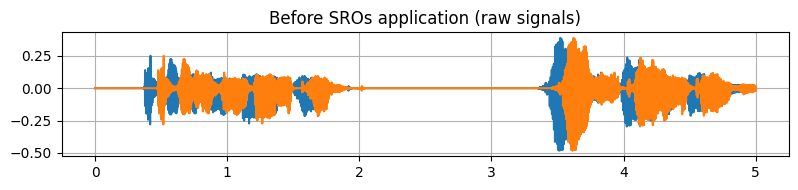

In [141]:
import soundfile as sf
from scipy import signal as sig
import copy

if signalType == 'noise':
    x1 = rng.uniform(-.5,.5,size=(len(t),1))
elif signalType == 'speech':
    x1, fsImport = sf.read('./test_sound.wav')
    # Truncate
    x1 = x1[:int(fsImport*dur), np.newaxis]
    if fsImport != fs:
        print(f'Resampling x to {fs} samples/s.')
        x1 = sig.resample(x1, axis=0, num=int(fs * dur))
x = np.repeat(x1, nSignals + 1, 1)

# Apply delays
if delayFromReference > 0:
    nSamplesDelay = int(delayFromReference * fs)
    for ii in range(1, nSignals + 1):
        xCopy = copy.copy(x[:, ii])
        x[:nSamplesDelay, ii] = 0
        x[nSamplesDelay:, ii] = xCopy[:-nSamplesDelay]

# Show signals
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.plot(t, x)
ax.grid()
ax.set_title('Before SROs application (raw signals)')
plt.tight_layout()	
plt.show()


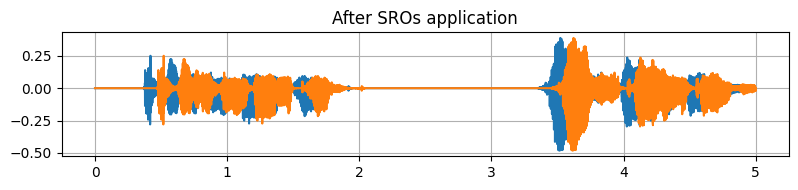

In [142]:
# APPLY SROs
x_out, t_out, fssro = apply_sro(x, fs, sensorToNodeTags, srosToTest, showSRO=False)

# Test plot
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.plot(t_out, x_out)
ax.grid()
ax.set_title('After SROs application')
plt.tight_layout()	
plt.show()

In [143]:
# COMPUTE CORRELATIONS
# chunkSize = 1000     # size of chunk to slide across the original, 0 ppm SRO, signal
correlationPeaks = np.zeros(nSignals + 1)
# r = np.zeros((x_out.shape[0] - chunkSize + 1, nSignals + 1))
r = np.zeros((x_out.shape[0]-1, nSignals + 1))
for ii in range(1, nSignals + 1):
    r[:, ii-1] = sig.correlate(x_out[:,0], x_out[:,ii]) 
    correlationPeaks[ii] = np.amax(r[:, ii])

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(211)
ax.plot(r[:, 0])
ax.grid()
ax.set_title('Correlation function')
ax = fig.add_subplot(212)
ax.plot(srosToTest, correlationPeaks, '.-')
ax.grid()
ax.set_title('Max of correlation function')
ax.set_xlabel('SRO [ppm]')
plt.tight_layout()

ValueError: could not broadcast input array from shape (159999,) into shape (80000,)